In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from pytorchtools_Wasserstein_Transformer import EarlyStopping

from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR

import scipy.stats as st

from matplotlib.offsetbox import AnchoredText
import math

In [14]:
#GPU
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout = 0.1, max_len = 512):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [4]:
class Transformer(nn.Module):
    def __init__(self, d_model, num_layers, p, neg_slope, n_head, pos_dropout):
        super(Transformer, self).__init__()

        self.dmodel = d_model
        self.encoder_layer = nn.TransformerEncoderLayer(d_model = d_model, nhead = n_head, dim_feedforward = 2048, dropout = 0.25, batch_first = False, dtype = torch.float)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer = self.encoder_layer, num_layers = num_layers)
        self.pos_encoder = PositionalEncoding(d_model = d_model, dropout = pos_dropout)
        
        self.linear = nn.Linear(3, d_model)
        
        self.fcff = nn.Sequential(
          
            nn.Linear(512, 1200, device = device),
            nn.BatchNorm1d(1200),
            nn.Dropout1d(p = p),
            nn.LeakyReLU(neg_slope),
            
            nn.Linear(1200, 450, device = device),
            nn.BatchNorm1d(450),
            nn.Dropout1d(p = p),
            nn.LeakyReLU(neg_slope),

            nn.Linear(450, 30, device = device),
            nn.BatchNorm1d(30),
            nn.Dropout1d(p = p),
            nn.LeakyReLU(neg_slope),

            nn.Linear(30, 5,  device = device),
        )
        
        self.apply(self._init_weights)
    
    def _init_weights(self,module):
        
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, 0, 0.1)
            if module.bias is not None:
                module.bias.data.fill_(0.08)
        
    
    def forward(self, x1, x2):

        x1 = x1.permute(1, 0, 2)
        x1 = self.linear(x1)
        x1 = self.pos_encoder(x1 * torch.sqrt(torch.tensor(self.dmodel)))
        x1 = self.transformer_encoder(x1)
        x1 = x1.permute(1, 0, 2)
        x1 = torch.flatten(x1, 1)
        x1 = self.fcff(x1)

        x2 = x2.permute(1, 0, 2)
        x2 = self.linear(x2)
        x2 = self.pos_encoder(x2 * torch.sqrt(torch.tensor(self.dmodel)))
        x2 = self.transformer_encoder(x2)
        x2 = x2.permute(1, 0, 2)
        x2 = torch.flatten(x2, 1)
        x2 = self.fcff(x2)
        
        output = torch.cdist(x1,x2, p = 2)
        
        return output

def classes_reg(dist, targets):
    
    reg = 0
    
    for clas in [1,2,3,4]:
        ind = torch.tensor(list(itertools.combinations_with_replacement(torch.nonzero(targets == clas)[:,0],2)))
        dist = dist.to('cpu')
        reg = reg + torch.sum(dist[ind[:,0],ind[:,1]])
                
    return reg

In [5]:
class MyLoss (nn.Sequential):
    def __init__(self):
        super(MyLoss, self).__init__()

    def forward(self, W, W_NN):
        
        loss = torch.mean((torch.abs(W_NN-W)/W) + ((torch.abs(W_NN-W)/(W_NN + 7e-3))))

        return loss


In [18]:
def Train(train, W_dist, n_batches_train):
    train_losses = []
    
    for batch in range (n_batches_train):

        W_dist_train = model(train[0][batch], train[1][batch]).to(device)

        loss = criterion(W_dist[batch], W_dist_train)
        # loss_reg = Reg_Loss(loss, LAMBDA, SIGMA, E_dist_train, targest)
        train_losses.append(loss_reg.item())

        optimizer.zero_grad()
        loss_reg.requires_grad_()
        loss_reg.backward(retain_graph=True)

        optimizer.step()

    return train_losses

In [19]:
def Validation(validation, W_dist):
    
    Wasserstein_dist = model(validation[0], validation[1]).to(device)
    valid_loss = criterion(W_dist, Wasserstein_dist)
    
    return valid_loss


In [20]:
def Test(test, W_dist):
    
    Wasserstin_dist = model(test[0], test[1]).to(device)
    test_loss = criterion(W_dist, Wasserstein_dist)
    print(test_loss)
    
    return Wasserstein_dist


In [12]:
def dataset_maker(data, dist):
    
    ind = torch.nonzero(dist)
    dist = dist[ind[:,0], ind[:,1]].view(ind.size(0), 1)
    data = torch.cat((data[ind[:,0]], data[ind[:,1]]), dim = 1)
    
    return [data, dist]

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

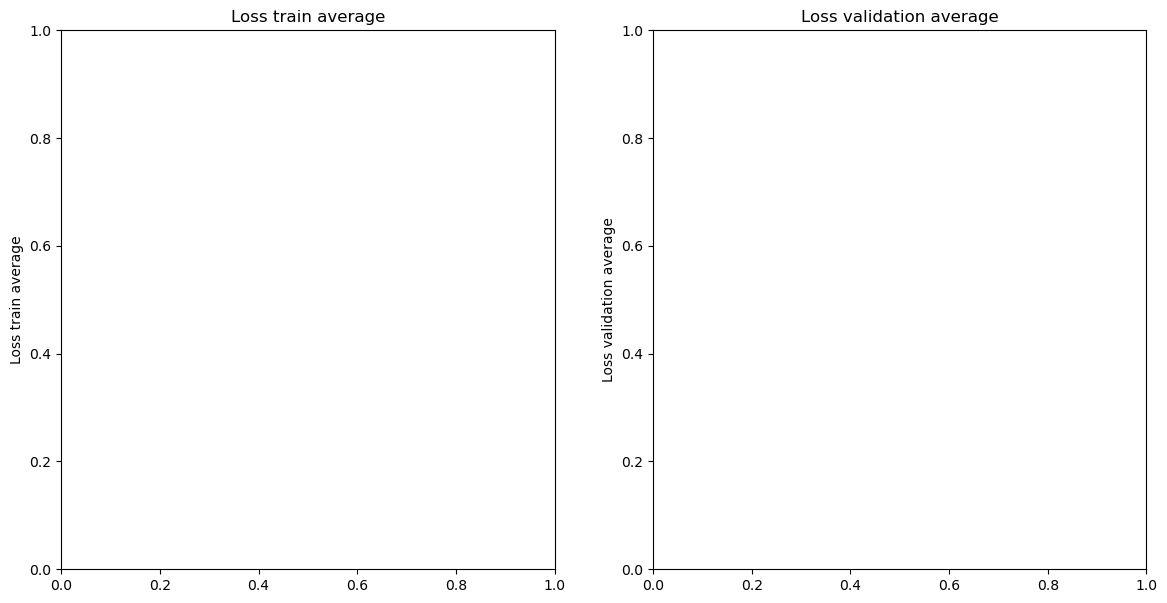

In [21]:
#Dataloder
# device = 'cuda:0'
train, _ = torch.load('/home/gbortolai/Thesis/data/Jets/dataset_train', map_location=device)
validation, _  = torch.load('/home/gbortolai/Thesis/data/Jets/dataset_validation', map_location=device)

W_dist_train, _ = torch.load('/home/gbortolai/Thesis/data/Jets/Wasserstein_dist_train_s=12000', map_location=device)
W_dist_validation, _ = torch.load('/home/gbortolai/Thesis/data/Jets/Wasserstein_dist_validation_s=2400', map_location=device)

train = train.to(torch.float)
validation = validation.to(torch.float)

# ind_train = torch.nonzero(W_dist_train)
# ind_validation = torch.nonzero(W_dist_validation)

# W_dist_train = W_dist_train[ind_train[:,0], ind_train[:,1]].view(ind_train.size(0), 1)
# W_dist_validation = W_dist_validation[ind_validation[:,0], ind_validation[:,1]].view(ind_validation.size(0), 1)

# train = torch.cat((train[ind_train[:,0]], train[ind_train[:,1]], W_dist_train), dim = 1)
# validation = torch.cat((validation[ind_validation[:,0]], validation[ind_validation[:,1]], W_dist_validation), dim = 1)

train, W_dist_train = dataset_maker(train, W_dist_train)
validation, W_dist_validation = dataset_maker(validation, W_dist_validation)

#parameters

n_sample_train = train.size(0)
batch_size = 300
n_batches_train = int(n_sample_train/batch_size)

train = torch.stack(torch.chunk(train, n_batches_train, dim = 0), dim = 0)
W_dist_train = torch.stack(torch.chunk(W_dist_train, n_batches_train, dim = 0), dim = 0)

d_model = 32
num_layers = 2
n_head = 4
pos_dropout = 0.1

#Train
#-----------------------------------------------------------------------------------------------------------SETTING
learning_rate = 1e-3

criterion = MyLoss()
# criterion = nn.MSELoss()

LAMBDA = 0

patience = 30
iteration = 1000
neg_slope = 1e-2
p = 0.1

model = Transformer(d_model, num_layers, p, neg_slope, n_head, pos_dropout).to(device)
optimizer = optim.Adam(model.parameters(),lr = learning_rate, weight_decay = 0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.5)
early_stopping = EarlyStopping(patience = patience, verbose = True)

fig = plt.figure(figsize = (14, 7), constrained_layout=False)
gs = GridSpec(1, 2, figure = fig)

ax3 = fig.add_subplot(gs[0, 0])
ax3.set_title('Loss train average')
ax3.set_ylabel('Loss train average')
ax3.set_ybound(lower = 0, upper = None)

ax4 = fig.add_subplot(gs[0, 1])
ax4.set_title('Loss validation average')
ax4.set_ylabel('Loss validation average')
ax4.set_ybound(lower = 0, upper = None)

for ite in range (iteration):
    #Train
    model.train()
    train_losses = Train(train, W_dist_train, n_batches_train)
    train_loss = np.average(train_losses)
    ax3.scatter(ite, train_loss, color = 'b', s = 5)

    #Validation
    model.eval()
    valid_loss = Validation(validation, W_dist_validation)
    ax4.scatter(ite, valid_loss.cpu().detach().numpy(), color = 'b', s = 5)

    early_stopping(valid_loss, model)
    scheduler.step()


    if early_stopping.early_stop:
            print("Early stopping")
            break

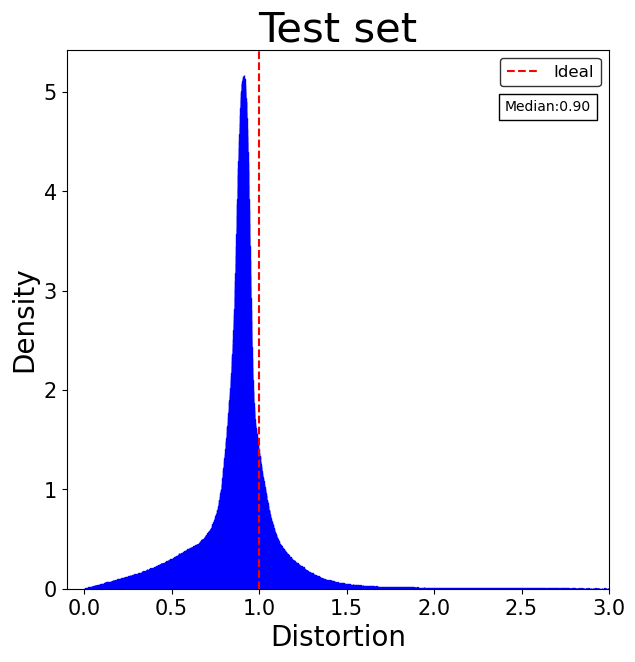

In [21]:
device = 'cpu'
test, _ = torch.load('/home/gbortolai/Thesis/data/Jets/dataset_test', map_location = device)
W_dist_test, targets_test = torch.load('/home/gbortolai/Thesis/data/Jets/Wasserstein_dist_test_s=4000', map_location = device)

test = test.to(torch.float)

criterion = MyLoss()

neg_slope = 1e-2
p = 0.1
d_model = 32
num_layers = 2
n_head = 4
pos_dropout = 0.1

model = Transformer(d_model, num_layers, p, neg_slope, n_head, pos_dropout).to(device)
model.load_state_dict(torch.load('/home/gbortolai/Thesis/Checkpoint/checkpoint_transformer_simple.pth', map_location = device))

model.eval()

# sample_emb_test = Test(test, W_dist_test)
dist.append(Test(test, W_dist_test))

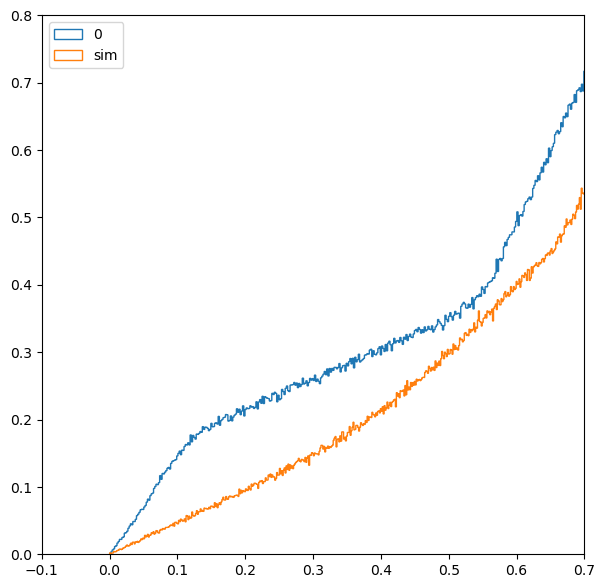

In [23]:
colors = ['b', 'g', 'r','c','m','y','k']
label = ['0', 'sim']

fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.set_xlim([-0.1, 0.7])
ax.set_ylim([0,0.8])

for i in range(len(dist)):
    ax.hist(dist[i].detach().numpy(), bins = 'auto', density = True, fill = False, label = label[i], histtype='step')
ax.legend(loc = 'upper left')
fig.savefig('/home/gbortolai/Thesis/Plot/Jets/Simple/Distortion_reg_sim_zoom.pdf')

In [ ]:
dist = torch.load('/home/gbortolai/Thesis/data/Jets/dist_multi_2-7', map_location = device)

fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.set_xlim([0.75, 1])
# ax.set_ylim([0,1])
ax.set_title('Test set distortions', fontsize = 20)
ax.set_xlabel('Distortions', fontsize = 15)
ax.set_ylabel('Density', fontsize = 15)

colors = ['b', 'g', 'r','c','m','y','k']
for i in [2,3,4,5,6,7]:
    ax.hist(dist[i-2].detach().numpy(), bins = 'auto', density = True, fill = False, color = colors[i-2], label = str(i)+'D', histtype='step')
ax.legend(loc = 'best')
# fig.savefig('/home/gbortolai/Thesis/Plot/Jets/Simple/Distortions_peaks.pdf', facecolor='w',pad_inches=0.3, transparent=True)

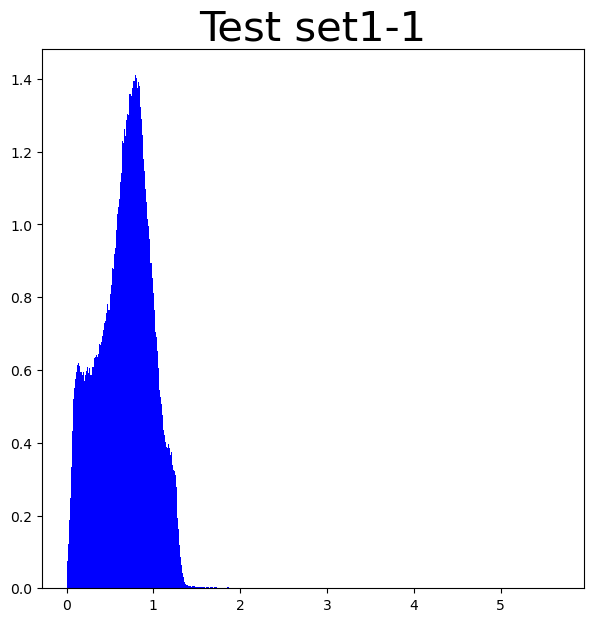

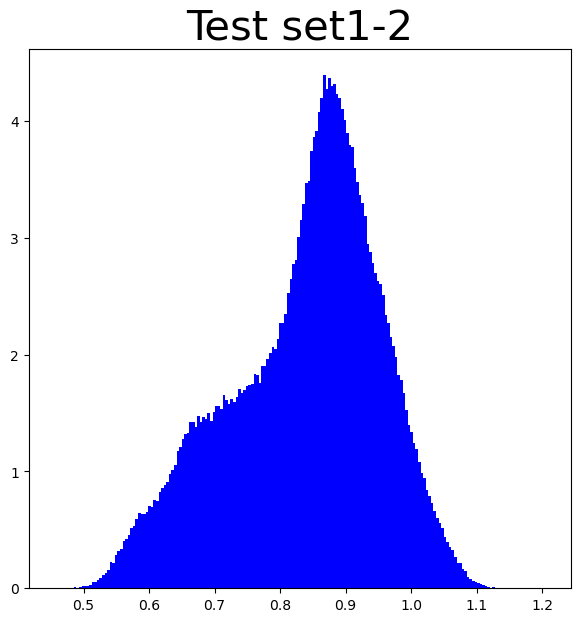

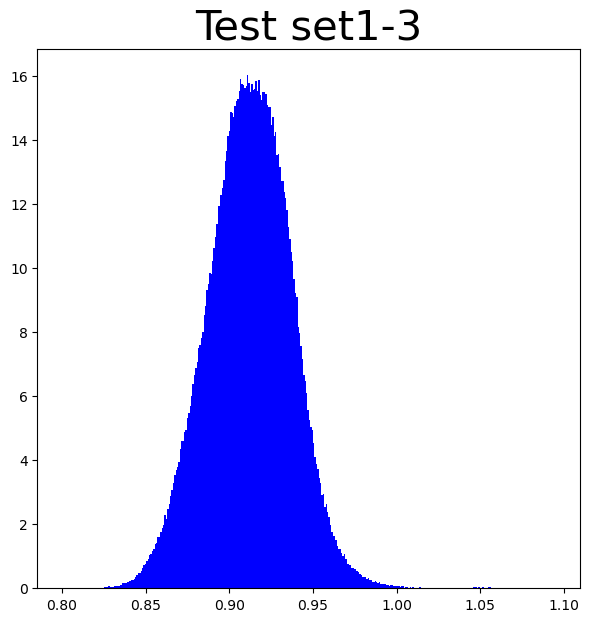

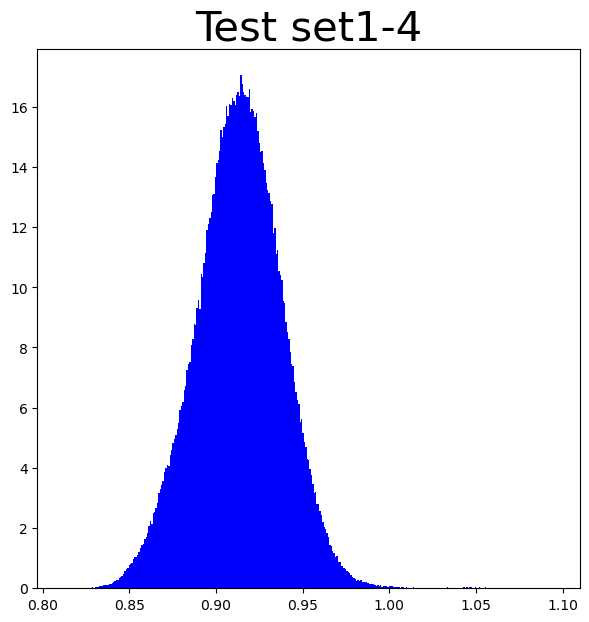

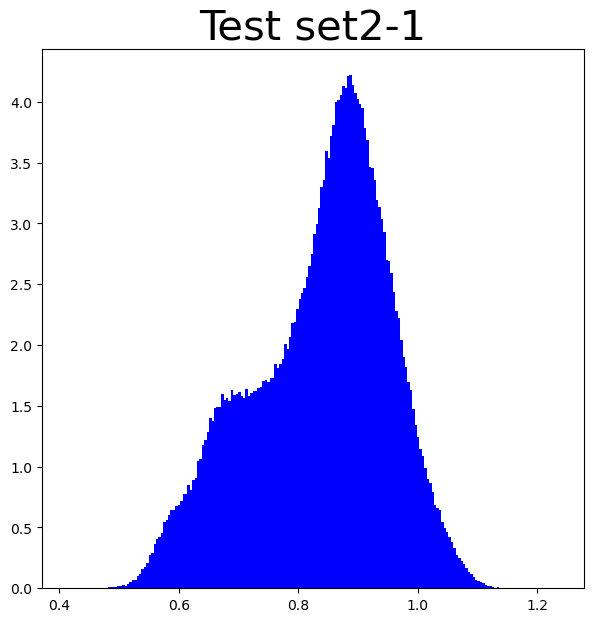

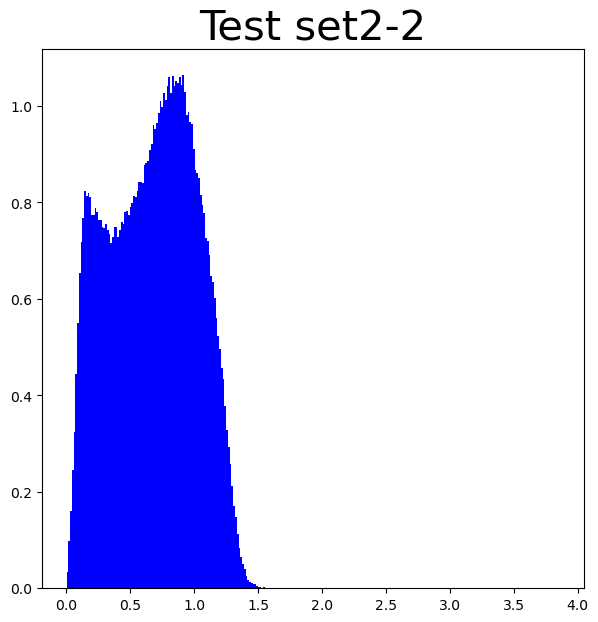

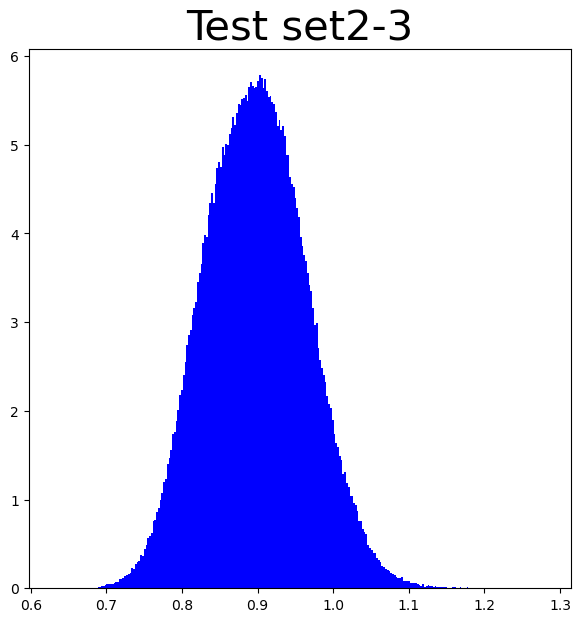

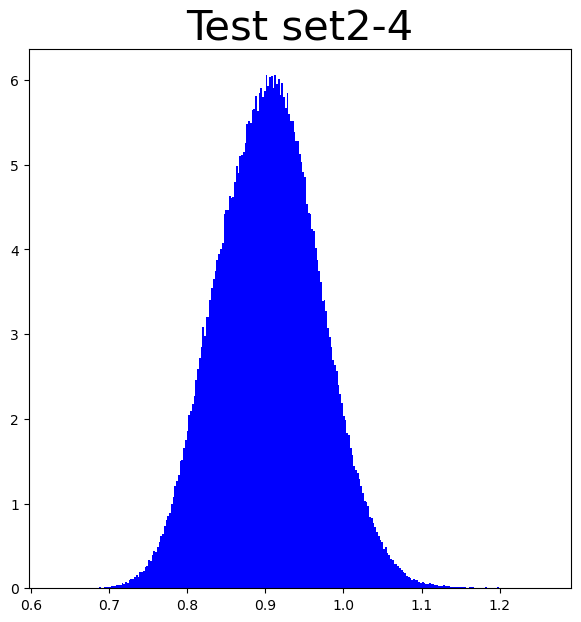

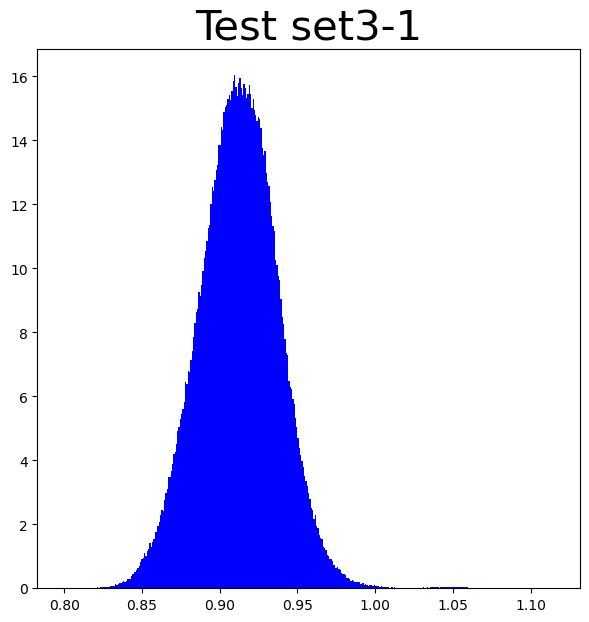

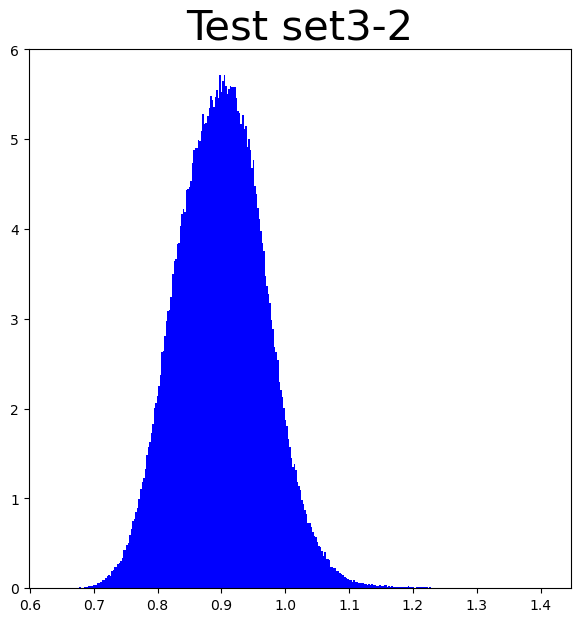

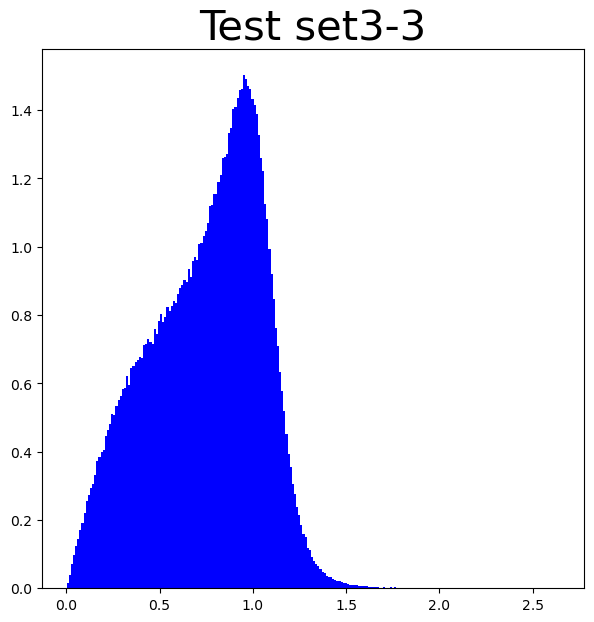

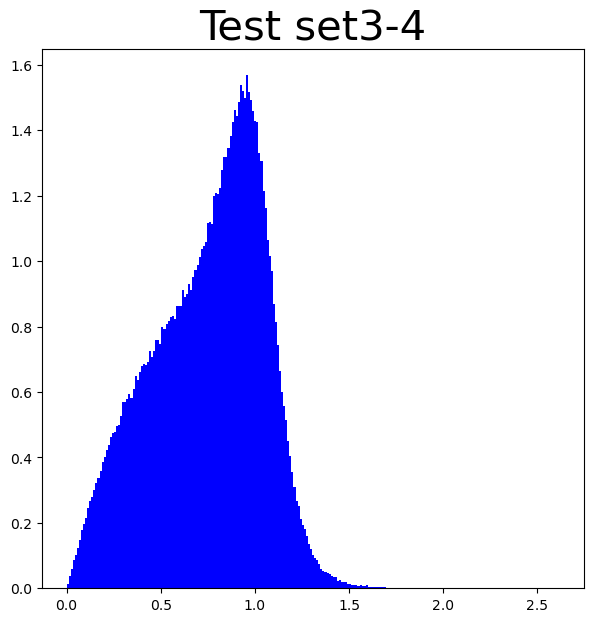

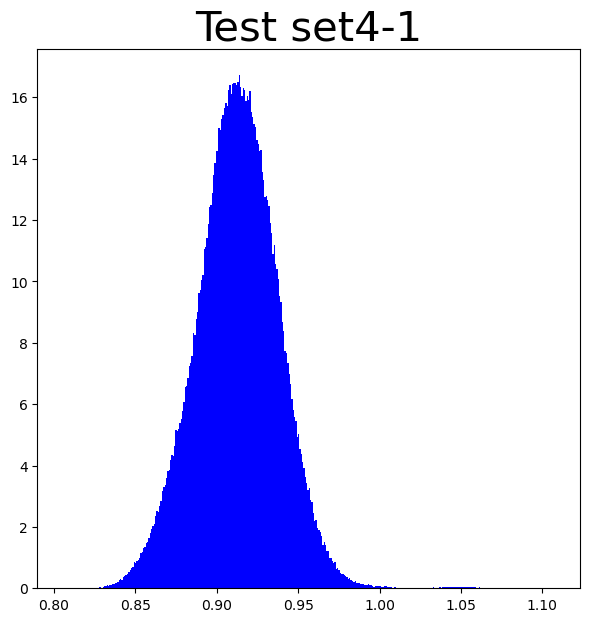

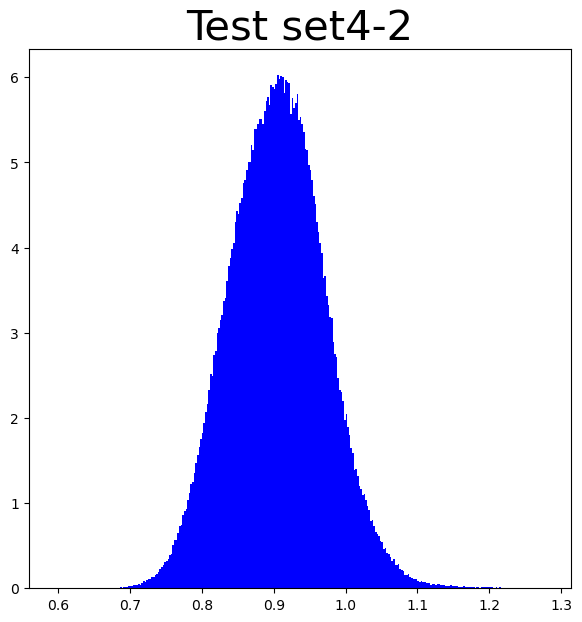

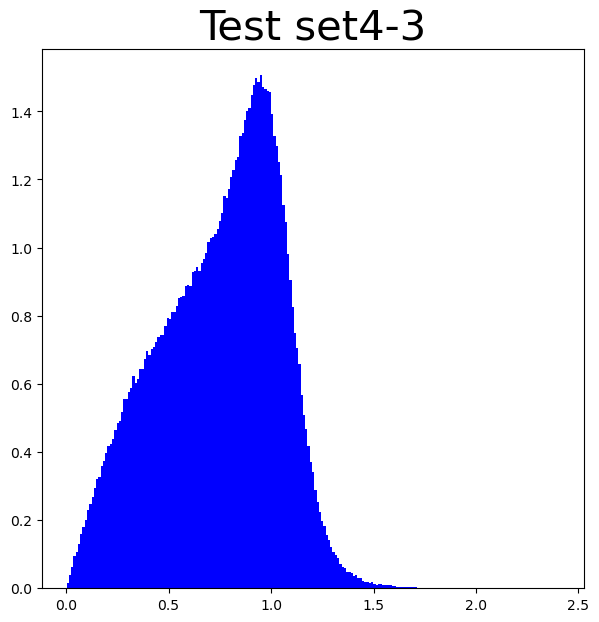

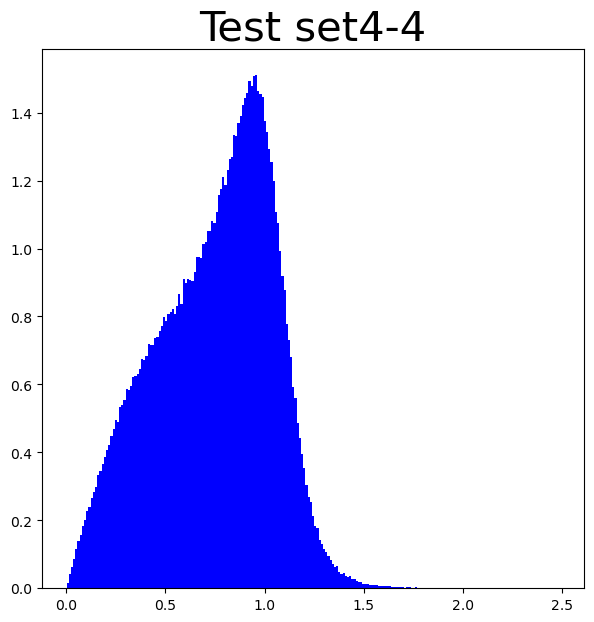

In [36]:
E_dist_test = torch.cdist(sample_emb_test[0], sample_emb_test[1], p=2)

for prongx in [1,2,3,4]:
    for prongy in [1,2,3,4]:
        fig, ax = plt.subplots(1,1, figsize=(7,7))
        ax.set_title(f'Test set {prongx}-{prongy}', fontsize = 30)
        subW = torch.zeros(torch.count_nonzero(targets_test == prongx).item(), torch.count_nonzero(targets_test == prongy).item())
        subE = torch.zeros(torch.count_nonzero(targets_test == prongx).item(), torch.count_nonzero(targets_test == prongy).item())

        l = 0
        for i in torch.nonzero(targets_test == prongx)[:,0]:
            m = 0
            for j in torch.nonzero(targets_test == prongy)[:,0]:
                subW[l][m] = W_dist_test[i][j]
                subE[l][m] = E_dist_test[i][j]
                m = m+1
            l = l+1

        dist = Dist(subW, subE)
        ax.hist(dist.detach().numpy(), bins = 'auto', color = 'b', density = True)

def Test(test, W_dist_test):
    criterion = MyLoss()
    #criterion = nn.MSELoss()

    neg_slope = 1e-2

    p = 0.1

    d_model = 32
    num_layers = 2
    n_head = 4
    pos_dropout = 0.1


    model = Transformer(d_model, num_layers, p, neg_slope, n_head, pos_dropout).to(device)


    #test 
    model.load_state_dict(torch.load('/home/gbortolai/Thesis/Checkpoint/checkpoint_transformer_simple_old.pth', map_location = device))
    #-----------------------------------------------------------------------------------SETTING
    model.eval()
    #--------------------------------------------------------------------------------------EMBEDDING

    sample_emb_test = model(test, test).to(device)

    E_dist_test = torch.cdist(sample_emb_test[0], sample_emb_test[1], p = 2).to(device)

    test_loss = criterion(W_dist_test, E_dist_test)
    test_dist = Dist(W_dist_test, E_dist_test)
    # test_loss_reg = Reg_Loss(test_loss, LAMBDA)

    # test_dist_mean = torch.mean(test_dist)
    # var_test = np.sqrt(torch.mean((1-test_dist_mean)*(1-test_dist_mean)).cpu().detach().numpy())

    # median_test = torch.median(test_dist)

    # print('Dist mean:', test_dist_mean.item(),u"\u00B1", var_test.item())
    print(test_loss)
#     fig3, ax3_test = plt.subplots(1,1, figsize=(7,7))

#     ax3_test.set_title(f'Test set{prongx}-{prongy}', fontsize = 30)

#     # ax3_test.set_xlim([-0.1,1.5])
#     ax3_test.set_xlabel("Distortion", fontsize = 20)
#     ax3_test.set_ylabel("Density", fontsize = 20)
#     ax3_test.tick_params(axis='both', which='major', labelsize=15)
#     labels = ['Ideal']#, 'mode', 'mean','median']
#     #plt.axhline(y=1, color='r', linestyle='-')
#     #for i in range(targets_test.size(0)):
#         #if targets_test[i] == 2:
#     count_test, bins_test, p_test = ax3_test.hist(test_dist.cpu().detach().numpy(), color = 'b', bins = 'auto', density = True, edgecolor = 'b')
#     ax3_test.axvline(x=1, color='r', linestyle='dashed')

#     mode_index_test = count_test.argmax()
#     mode_test = (bins_test[mode_index_test] + bins_test[mode_index_test+1])/2
#     var_mode_test = np.sqrt(np.average((1-mode_test)*(1-mode_test)))

#     # ax3_test.axvline(x=mode_test, color='green', linestyle='-')
#     # ax3_test.axvline(x=test_dist_mean.cpu().detach().numpy(), color='yellow', linestyle='-')
#     # ax3_test.axvline(x=median_test.cpu().detach().numpy(), color='purple', linestyle='-')
#     #plt.axvline(x=test_loss.detach().numpy(), color='orange', linestyle='-')
#     ax3_test.legend(labels, fontsize = 12, loc = 'upper right', edgecolor = 'black',  bbox_to_anchor=(1, 1), bbox_transform=ax3_test.transAxes)

#     # anchored_text_test = AnchoredText('Mode:'+str('%.3f' % mode_test.item())+u"\u00B1"+str('%.3f' % var_mode_test.item())+'\nDist:'+str('%.3f' % test_dist_mean.item())+u"\u00B1"+str('%.3f' % var_test.item()+'\nMedian:'+str('%.3f' % median_test.item())), loc='lower right')
#     anchored_text_test = AnchoredText('Median:'+str('%.2f' % median_test.item()), loc='upper right', bbox_to_anchor = (0.99,0.93), bbox_transform=ax3_test.transAxes)
#     # ax3_test.text(0.8, 0.83,'Mode:'+str('%.2f' % mode_test.item())+'\nDist:'+str('%.2f' % test_dist_mean.item())+'\nMedian:'+str('%.2f' % median_test.item()), transform=ax3_test.transAxes, bbox=dict(facecolor='white'))
#     ax3_test.add_artist(anchored_text_test)
#     # fig3.savefig(f'/home/gbortolai/Thesis/Plot/Jets/Simple/Transformer{prongx}-{prongy}.pdf', facecolor='w',pad_inches=0.3, transparent=True)
    return test_dist

test, _ = torch.load('/home/gbortolai/Thesis/data/Jets/dataset_test', map_location=device)
W_dist_test, target_test = torch.load('/home/gbortolai/Thesis/data/Jets/Wasserstein_dist_test_s=4000', map_location=device)

test = test.to(torch.float)

# subdata = torch.zeros(torch.count_nonzero(target_test == 1).item(), 16, 3)
# subW = torch.zeros(torch.count_nonzero(target_test == 1).item(), torch.count_nonzero(target_test == 1).item())

dist = []
for prongx in [1,2,3,4]:
    subdata = torch.zeros(torch.count_nonzero(target_test == prongx).item(), 16, 3)
    subW = torch.zeros(torch.count_nonzero(target_test == prongx).item(), torch.count_nonzero(target_test == 1).item())
    for prongy in [1,2,3,4]:
        l = 0
        for i in torch.nonzero(target_test == prongx)[:,0]:
            subdata[l] = test[i]
            m = 0
            for j in torch.nonzero(target_test == prongy)[:,0]:
                subW[l][m] = W_dist_test[i][j]
                m = m+1
            l = l+1
        dist.append(Test(subdata, subW))



# plt.hist(dist.detach().numpy(), bins = 'auto')

fig, ax = plt.subplots(1,1, figsize=(7,7))

# ax3_test.set_title(f'Test set{prongx}-{prongy}', fontsize = 30)

ax.set_xlim([-0.1,3])

ax.hist(torch.cat(dist, dim = 0).detach().numpy(), bins = 'auto', color = 'b', density = True)
# print(dist[0])

In [62]:
print(subW)

tensor([[0.0000, 0.2988, 0.4325,  ..., 0.4591, 0.4477, 0.4696],
        [0.0000, 0.0000, 0.2871,  ..., 0.3451, 0.3435, 0.4471],
        [0.0000, 0.0000, 0.0000,  ..., 0.1082, 0.1237, 0.3726],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0485, 0.3523],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.3559],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [ ]:
# dist = torch.cat(torch.chunk(torch.cat(dist, dim = -1), 4000, dim = -1), dim = 0)
# print(torch.cat(dist, dim = 0).size())
# a = plt.hist(subW.detach().numpy(), color = 'b', density = True, bins = 'auto')
print(subW.size())
v = []
for i in range(1000):
        for j in filter(lambda h: h>i, range(1000)):
            v.append(subW[i][j].item())
plt.hist(v, bins = 'auto', linewidth = 0.8, alpha = 0.5, density = True, color = 'b')

In [13]:
# fig3.savefig('/home/gbortolai/Thesis/Plot/Jets/Simple/Transformer_3D.pdf', facecolor='w',pad_inches=0.3, transparent=True)

NameError: name 'fig3' is not defined

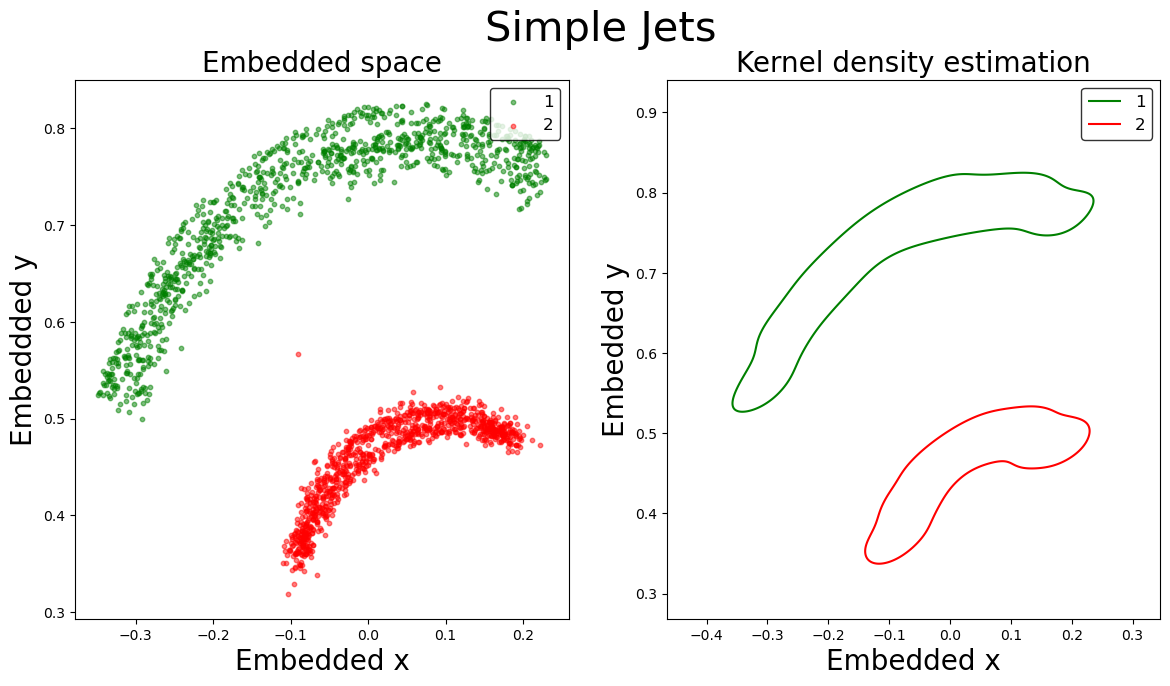

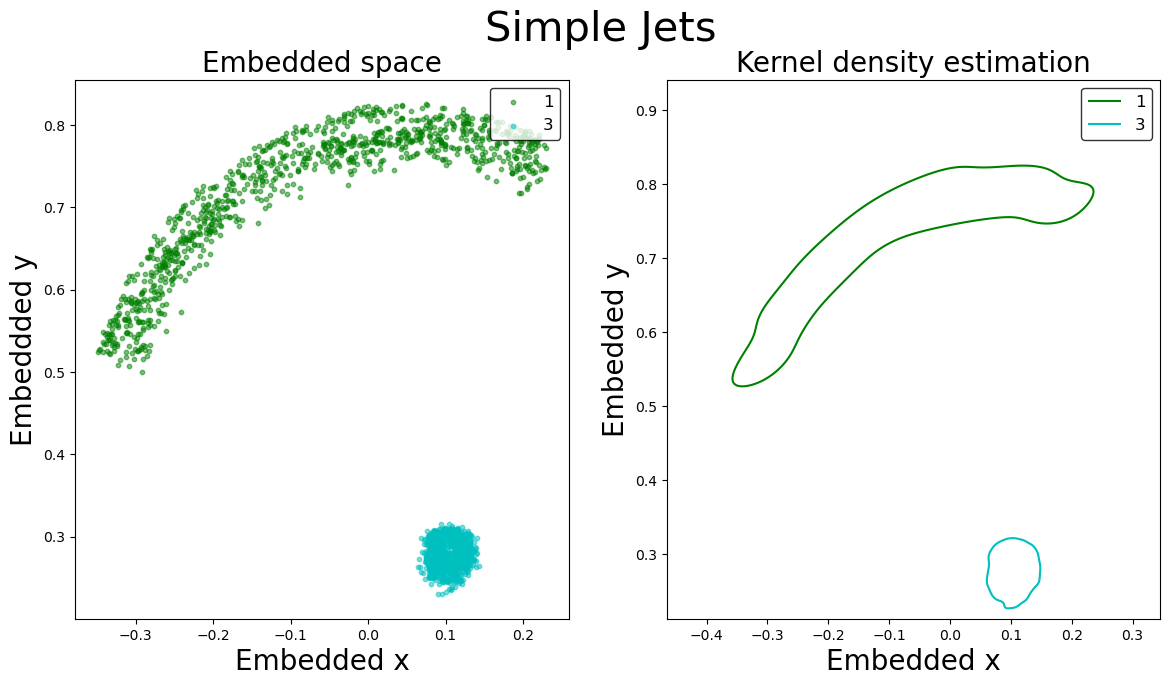

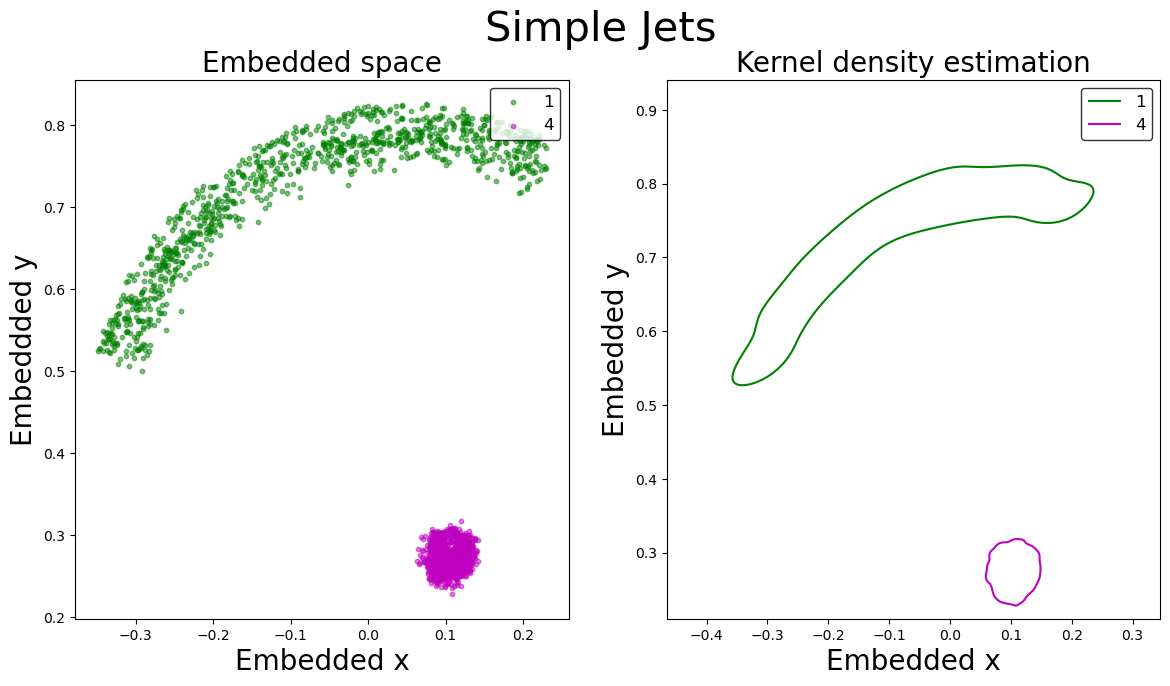

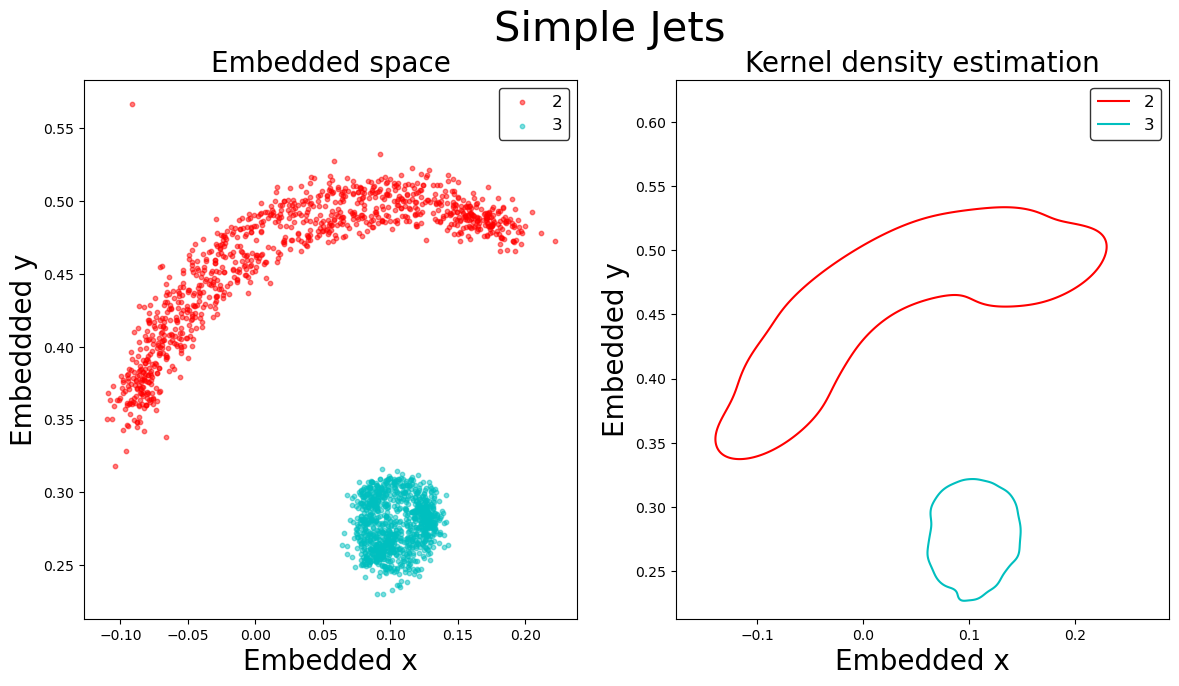

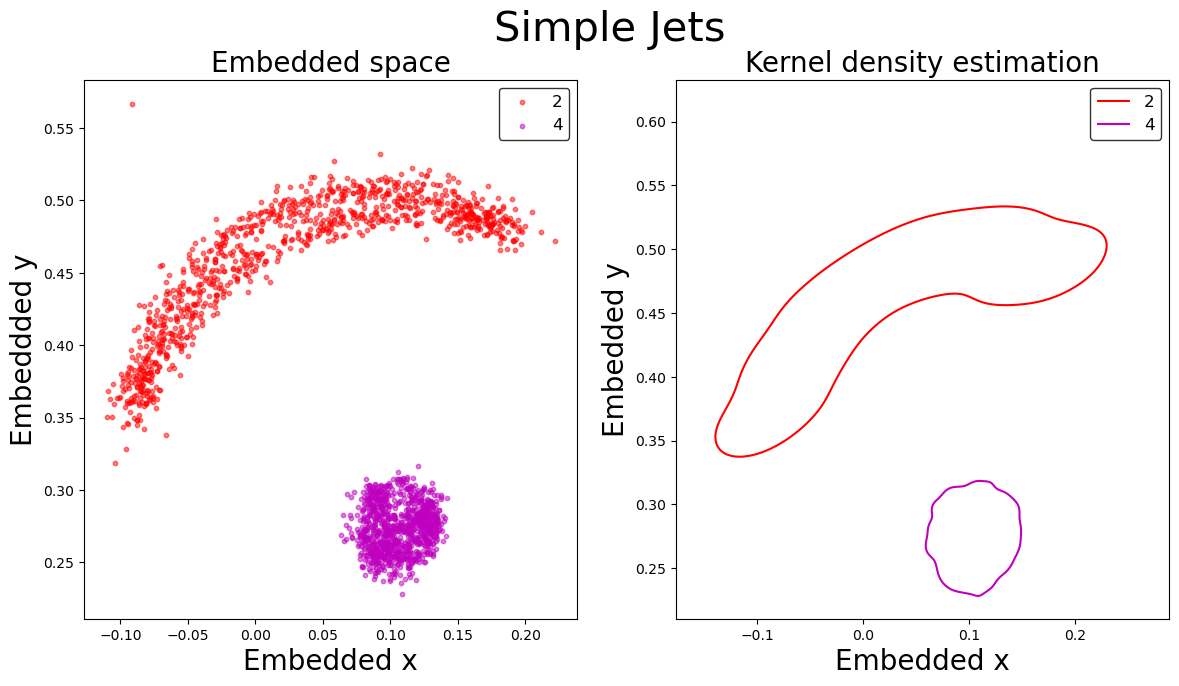

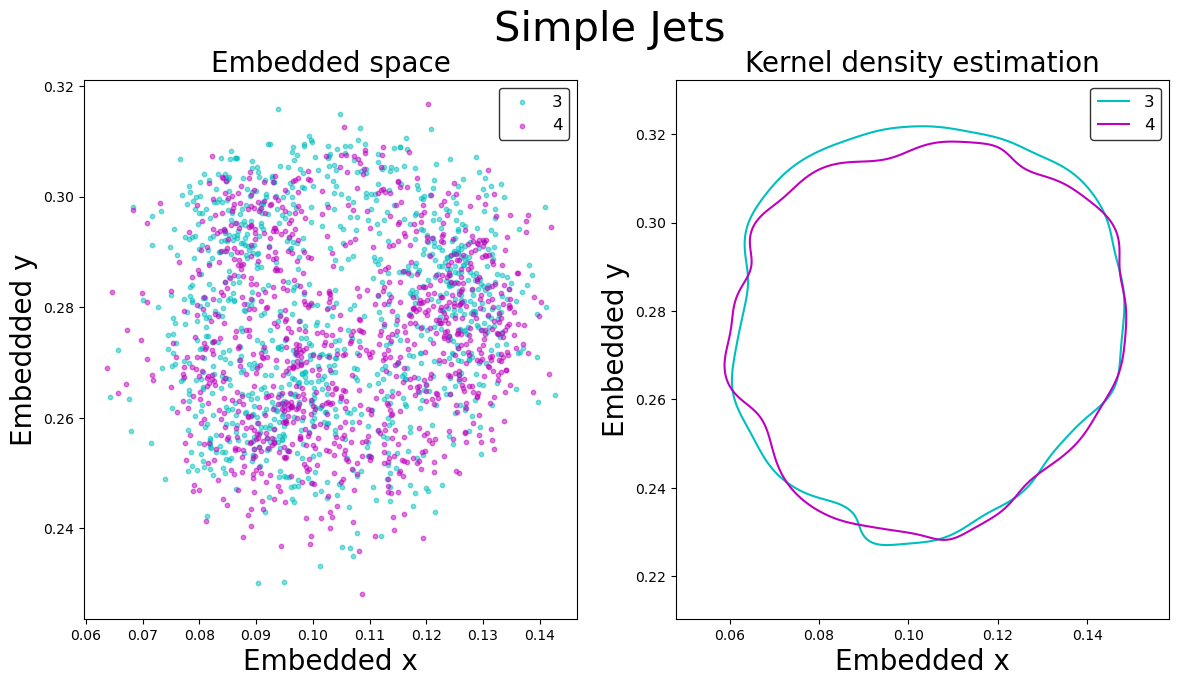

In [26]:
#------------------------------------------------------------------------------------PLOT
labels = ['1','2','3','4']

colors = ['g', 'r','c','m']

var, col = [], []

n_bullet = 0
n_target = 0

for n_bullet in [1,2,3,4]:
    for n_target in [1,2,3,4]:
        if n_target > n_bullet:
            fig_test = plt.figure(figsize=(14, 7), constrained_layout=False)
            gs_test = GridSpec(1, 2, figure = fig_test)

            fig_test.suptitle('Simple Jets', fontsize = 30)

            ax1_test = fig_test.add_subplot(gs_test[0, 1])
            ax1_test.set_title('Kernel density estimation', fontsize = 20)
            ax1_test.set_xlabel('Embedded x', fontsize = 20)
            ax1_test.set_ylabel('Embedded y', fontsize = 20)

            ax2_test = fig_test.add_subplot(gs_test[0,0])
            ax2_test.set_title('Embedded space', fontsize = 20)
            ax2_test.set_xlabel('Embedded x', fontsize = 20)
            ax2_test.set_ylabel('Embeddded y', fontsize = 20)

            for j in [n_bullet,n_target]:
                for i in torch.nonzero( targets_test == j)[:,0]:
                    ax2_test.scatter(sample_emb_test[0][i][0].cpu().detach().numpy(), sample_emb_test[0][i][1].cpu().detach().numpy(), color = colors[j-1], s=10, alpha = 0.5)
                var.append(labels[j-1])
                col.append(colors[j-1])

            ax2_test.legend(var, fontsize = 12, loc = 'upper right', edgecolor = 'black',  bbox_to_anchor=(1, 1), bbox_transform=ax2_test.transAxes)

            leg = ax2_test.get_legend()    
            for i in range(len(var)):

                leg.legend_handles[i].set_color(col[i])
            #------------------------------------------------------KDE
            #fig, ax = plt.subplots()

            h = []

            for k in [n_bullet,n_target]:
                ind = torch.count_nonzero(targets_test == k)
                X = torch.zeros(1,1).expand(ind, 2).clone()

                l=0
                for i in torch.nonzero(targets_test == k)[:,0]:

                    X[l] = sample_emb_test[0][i]
                    l = l+1


                # Extract x and y
                x = X[:, 0]
                y = X[:, 1]

                # Define the borders
                deltaX = (torch.max(x) - torch.min(x))/5
                deltaY = (torch.max(y) - torch.min(y))/5
                xmin = torch.min(x).item() - deltaX.item()
                xmax = torch.max(x).item() + deltaX.item()
                ymin = torch.min(y).item() - deltaY.item()
                ymax = torch.max(y).item() + deltaX.item()

                # Create meshgrid
                xx, yy = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]

                x = x.detach().numpy()
                y = y.detach().numpy()

                positions = np.vstack([xx.ravel(), yy.ravel()])
                values = np.vstack([x, y])

                kernel = st.gaussian_kde(values)
                # kernel.set_bandwidth(bw_method=0.8)

                f = np.reshape(kernel(positions).T, xx.shape)


                #ax1_test = plt.gca()
                cset = ax1_test.contour(xx, yy, f, levels = [10], colors=colors[k-1])
                h1, l1 = cset.legend_elements()
                h.append(h1[0])

            ax1_test.legend(h, var, fontsize = 12, loc = 'upper right', edgecolor = 'black',  bbox_to_anchor=(1, 1), bbox_transform=ax1_test.transAxes)
            var, col, h = [], [], [] 
            fig_test.savefig('/home/gbortolai/Thesis/Plot/Jets/Simple/KDE_MyLoss/KDE'+str([n_bullet,n_target])+'.pdf', facecolor='w',pad_inches=0.3, transparent=True)
plt.show()

In [ ]:
torch.save([sample_emb_test, targets_test],'/home/gbortolai/Thesis/data/MNIST/sample_emb_test_s='+str(test.size(0)))

In [ ]:
fig_test.savefig('/home/gbortolai/Thesis/Plot/MNIST/Embedding.pdf', facecolor='w',pad_inches=0.3, transparent=True)

In [45]:
#plotting E_dist emb

E = torch.triu(torch.cdist(sample_emb_test[0], sample_emb_test[0], p = 2))
torch.save([E, targets_test],'/home/gbortolai/Thesis/data/Jets/E_dist_emb_transformer_s='+str(test.size(0)))

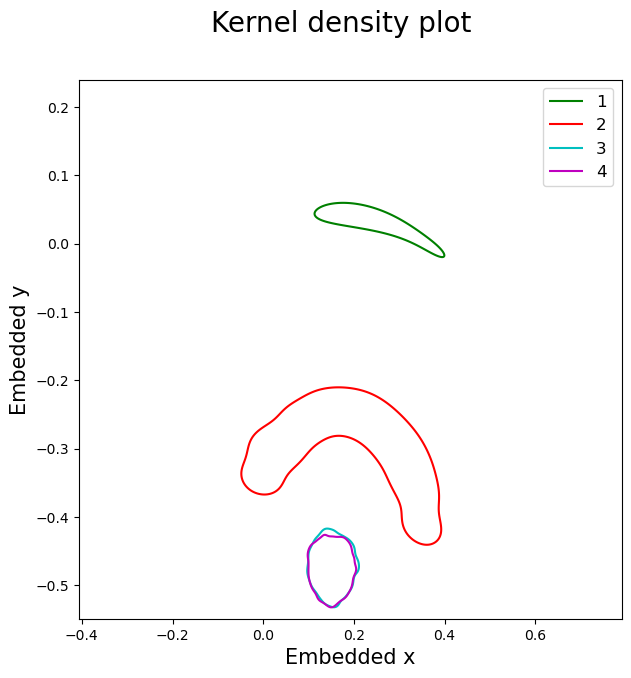

In [52]:
labels = ['1','2','3','4']

colors = ['g', 'r','c','m']

fig, ax = plt.subplots(1,1, figsize = (7,7))
fig.suptitle('Kernel density plot', fontsize = 20)
ax.set_xlabel('Embedded x', fontsize = 15)
ax.set_ylabel('Embedded y', fontsize = 15)

lab, h = [], []

for k in [1,2,3,4]:
    ind = torch.count_nonzero(targets_test == k)
    X = torch.zeros(1,1).expand(ind, 2).clone()

    l=0
    for i in torch.nonzero(targets_test == k)[:,0]:
        X[l] = sample_emb_test[0][i]
        l = l+1


    # Extract x and y
    x = X[:, 0]
    y = X[:, 1]

    # Define the borders
    deltaX = (torch.max(x) - torch.min(x))/5
    deltaY = (torch.max(y) - torch.min(y))/5
    xmin = torch.min(x).item() - deltaX.item()
    xmax = torch.max(x).item() + deltaX.item()
    ymin = torch.min(y).item() - deltaY.item()
    ymax = torch.max(y).item() + deltaX.item()

    # Create meshgrid
    xx, yy = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]

    x = x.detach().numpy()
    y = y.detach().numpy()

    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])

    kernel = st.gaussian_kde(values)
    # kernel.set_bandwidth(bw_method=0.8)

    f = np.reshape(kernel(positions).T, xx.shape)


    #ax1_test = plt.gca()
    #print(colors[k])
    cset = ax.contour(xx, yy, f, levels = [10], colors = colors[k-1])

    h1, l1 = cset.legend_elements()
    h.append(h1[0])
    lab.append(labels[k-1])

ax.legend(h, lab, loc = 'best', fontsize = 12)
# fig.savefig('/home/gbortolai/Thesis/Plot/Jets/Simple/KDE_1234_myloss_Transformer.pdf', facecolor='w',pad_inches=0.3, transparent=True)
lab, h = [], []

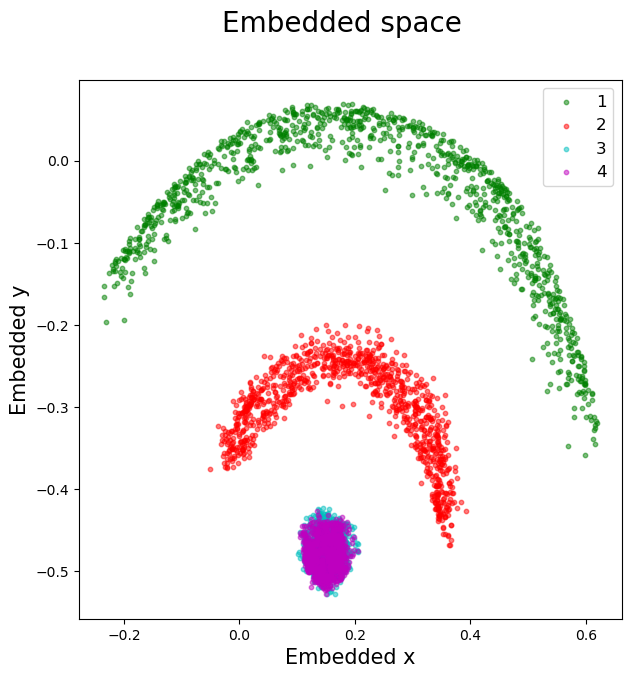

In [51]:
labels = ['1','2','3','4']

colors = ['g', 'r','c','m']

var, col = [], []

fig, ax = plt.subplots(1,1, figsize = (7,7))
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (10,10))

fig.suptitle('Embedded space', fontsize = 20)
ax.set_xlabel('Embedded x', fontsize = 15)
ax.set_ylabel('Embedded y', fontsize = 15)

for j in [1,2,3,4]:
    for i in torch.nonzero(targets_test == j)[:,0]:
        ax.scatter(sample_emb_test[0][i][0].cpu().detach().numpy(), sample_emb_test[0][i][1].cpu().detach().numpy(), color = colors[j-1], s=10, alpha = 0.5)
        # ax.scatter(sample_emb_test[0][i][0].cpu().detach().numpy(), sample_emb_test[0][i][1].cpu().detach().numpy(), sample_emb_test[0][i][2].cpu().detach().numpy(), color = colors[j], s=10, alpha = 0.5)
    var.append(labels[j-1])
    col.append(colors[j-1])
    
ax.legend(var,loc = 'best', fontsize = 12)

leg = ax.get_legend()    
for i in range(len(var)):

    leg.legend_handles[i].set_color(col[i])
    
# fig.savefig('/home/gbortolai/Thesis/Plot/Jets/Simple/Embedded_1234_myloss_transformer.pdf', facecolor='w',pad_inches=0.3, transparent=True)
var, col = [], []